# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.preprocessing import filtering as filt
from resurfemg.postprocessing import features as feat
from resurfemg.preprocessing import ecg_removal as ecg_rm
from resurfemg.postprocessing import quality_assessment as qa
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the sEMG data

In [15]:
config = Config()

base_path = config.get_directory('root_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    extension_regex='poly5',
    folder_levels=None)

In [63]:
# If you want to select another file:
btn_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('0004\\20230419T113930\\20230419_113930.Data14Ch…

### 1 cell to run from here!

In [126]:
import os
from glob import glob

# Recursively find all .Data8Raw.Poly5 files in base_path
poly5_files = glob(os.path.join(base_path, '**', '*.Data8Raw.Poly5'), recursive=True)

for emg_file_chosen in poly5_files:
    data_emg = Poly5Reader(emg_file_chosen)
    data_emg_samples = data_emg.samples[:data_emg.num_samples]
    fs_emg = data_emg.sample_rate
    n_ch = 4
    y_emg = data_emg_samples[:n_ch, :]
    t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]

    emg_timeseries = EmgDataGroup(
        y_emg,
        fs=fs_emg,
        labels=['Intercost','Dia R','Dia L', 'Abd'],
        units=n_ch*['uV'])

    emg_timeseries.run('filter_emg', hp_cf=40,lp_cf=200)
    emg_timeseries.set_ecg_idx(0)
    emg_timeseries.run('gating', gate_width_samples=fs_emg//10, overwrite=True)
    emg_timeseries.run('envelope', env_window=100)
    emg_timeseries.run('baseline')

    intercost = emg_timeseries.channels[0]
    intercost.detect_emg_breaths(peak_set_name='breaths')
    intercost.peaks['breaths'].detect_on_offset(baseline=intercost.y_baseline)

    emg_di_r = emg_timeseries.channels[1]
    emg_di_r.detect_emg_breaths(peak_set_name='breaths')
    emg_di_r.peaks['breaths'].detect_on_offset(baseline=emg_di_r.y_baseline)

    emg_di_l = emg_timeseries.channels[2]
    emg_di_l.detect_emg_breaths(peak_set_name='breaths')
    emg_di_l.peaks['breaths'].detect_on_offset(baseline=emg_di_l.y_baseline)

    emg_di_r.calculate_time_products(peak_set_name='breaths', parameter_name='AUC')
    emg_di_l.calculate_time_products(peak_set_name='breaths', parameter_name='AUC')
    intercost.calculate_time_products(peak_set_name='breaths', parameter_name='AUC')

    parameter_names = {'time_product': 'AUC'}
    emg_di_r.test_emg_quality(peak_set_name='breaths', parameter_names=parameter_names, verbose=False)
    emg_di_l.test_emg_quality(peak_set_name='breaths', parameter_names=parameter_names, verbose=False)
    intercost.test_emg_quality(peak_set_name='breaths', parameter_names=parameter_names, verbose=False)

    file_name = os.path.basename(emg_file_chosen).replace('.Data8Raw.Poly5', '')
    patient_number = os.path.basename(os.path.dirname(os.path.dirname(emg_file_chosen)))
    csv_dir = os.path.join(base_path, 'Analyzed_data_2')
    os.makedirs(csv_dir, exist_ok=True)

    # Dia R
    muscle = f"{patient_number}_{file_name}_dia_r"
    csv_path = os.path.join(csv_dir, muscle)
    dia_r = emg_di_r.peaks['breaths'].peak_df
    dia_r.to_csv(csv_path, index=False)

    # Dia L
    muscle = f"{patient_number}_{file_name}_dia_l"
    csv_path = os.path.join(csv_dir, muscle)
    dia_l = emg_di_l.peaks['breaths'].peak_df
    dia_l.to_csv(csv_path, index=False)

    # Intercost
    muscle = f"{patient_number}_{file_name}_intercost"
    csv_path = os.path.join(csv_dir, muscle)
    intercost_df = intercost.peaks['breaths'].peak_df
    intercost_df.to_csv(csv_path, index=False)


Reading file  P:\TNW\CRPH\Projects\2025_Mos_Isala\Raw_data\0004\20230419T113930\20230419_113930.Data8Raw.Poly5
	 Number of samples:  322140 
	 Number of channels:  21 
	 Sample rate: 500 Hz
Done reading data.
No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.
Set ECG channel used for ECG removal.
Reading file  P:\TNW\CRPH\Projects\2025_Mos_Isala\Raw_data\0004\20230421T132716\20230421_132716.Data8Raw.Poly5
	 Number of samples:  445185 
	 Number of channels:  21 
	 Sample rate: 500 Hz
Done reading data.
No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.
Set ECG channel used for ECG removal.
Reading file  P:\TNW\CRPH\Projects\2025_Mos_Isala\Raw_data\0005\20230525T112010\20230525_112011.Data8Raw.Poly5
	 Number of samples:  173745 
	 Number of channels:  21 
	 Sample rate: 500 Hz
Done reading data.
No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.
Set ECG channel used 

In [99]:
##pick muscle
#picked_muscle = 'dia_r'
#picked_muscle = 'dia_l'
picked_muscle = 'intercost'

csv_dir = os.path.join(base_path, 'Analyzed_data_2')



In [100]:
from collections import defaultdict

# List all files in the csv_dir that end with 'picked_muscle'
file_list = [f for f in os.listdir(csv_dir) if f.endswith(picked_muscle)]

# Prepare dictionaries to store opname and ontslag AUC arrays
AUC_opname_dict = {}
AUC_ontslag_dict = {}

# Group files by patient number

patient_files = defaultdict(list)
for fname in file_list:
    patient_number = fname[2:6]
    date = fname[7:13]
    patient_files[patient_number].append((date, fname))

# For each patient, find opname (lowest date) and ontslag (highest date)
for patient, file_list in patient_files.items():
    files_sorted = sorted(file_list, key=lambda x: x[0])
    opname_date, opname_fname = files_sorted[0]
    ontslag_date, ontslag_fname = files_sorted[-1]

    # Load opname file
    opname_fpath = os.path.join(csv_dir, opname_fname)
    opname_df = pd.read_csv(opname_fpath)
    valid_col = [col for col in opname_df.columns if col.lower() == 'valid']
    auc_col = [col for col in opname_df.columns if col.upper() == 'AUC']
    if valid_col and auc_col:
        auc_values = opname_df.loc[opname_df[valid_col[0]] == True, auc_col[0]].to_numpy()
        opname_header = opname_fname[:13]
        AUC_opname_dict[opname_header] = auc_values

    # Load ontslag file
    ontslag_fpath = os.path.join(csv_dir, ontslag_fname)
    ontslag_df = pd.read_csv(ontslag_fpath)
    valid_col = [col for col in ontslag_df.columns if col.lower() == 'valid']
    auc_col = [col for col in ontslag_df.columns if col.upper() == 'AUC']
    if valid_col and auc_col:
        auc_values = ontslag_df.loc[ontslag_df[valid_col[0]] == True, auc_col[0]].to_numpy()
        ontslag_header = ontslag_fname[:13]
        AUC_ontslag_dict[ontslag_header] = auc_values

In [101]:
## table of total and only true AUC values
# List all files in the csv_dir that end with 'picked_muscle'
file_list = [f for f in os.listdir(csv_dir) if f.endswith(picked_muscle)]

# Prepare dictionaries to store opname and ontslag AUC arrays
total_AUC_opname_dict = {}
total_AUC_ontslag_dict = {}

# Group files by patient number

patient_files = defaultdict(list)
for fname in file_list:
    patient_number = fname[2:6]
    date = fname[7:13]
    patient_files[patient_number].append((date, fname))

# For each patient, find opname (lowest date) and ontslag (highest date)
for patient, file_list in patient_files.items():
    files_sorted = sorted(file_list, key=lambda x: x[0])
    opname_date, opname_fname = files_sorted[0]
    ontslag_date, ontslag_fname = files_sorted[-1]

    # Load opname file
    opname_fpath = os.path.join(csv_dir, opname_fname)
    opname_df = pd.read_csv(opname_fpath)
    #valid_col = [col for col in opname_df.columns if col.lower() == 'valid']
    auc_col = [col for col in opname_df.columns if col.upper() == 'AUC']
    #if valid_col and auc_col:
    auc_values = opname_df[auc_col[0]].to_numpy()
    opname_header = opname_fname[:13]
    total_AUC_opname_dict[opname_header] = auc_values
    # Load ontslag file (could be same as opname if only one file)
    ontslag_fpath = os.path.join(csv_dir, ontslag_fname)
    ontslag_df = pd.read_csv(ontslag_fpath)
    #valid_col = [col for col in ontslag_df.columns if col.lower() == 'valid']
    auc_col = [col for col in ontslag_df.columns if col.upper() == 'AUC']
    #if valid_col and auc_col:
    auc_values = ontslag_df[auc_col[0]].to_numpy()
    ontslag_header = ontslag_fname[:13]
    total_AUC_ontslag_dict[ontslag_header] = auc_values

In [102]:
import pandas as pd

# Get all unique patient IDs from the opname and ontslag dicts
all_patient_ids = set(list(total_AUC_opname_dict.keys()) + list(AUC_opname_dict.keys()) +
                      list(total_AUC_ontslag_dict.keys()) + list(AUC_ontslag_dict.keys()))

# Use first 4 characters as patient id
def get_pid(key):
    return key[:4]

# Build a sorted list of unique patient ids
unique_pids = sorted(set(get_pid(k) for k in all_patient_ids))

rows = []
for pid in unique_pids:
    # Find keys for this patient in each dict
    opname_total_keys = [k for k in total_AUC_opname_dict if get_pid(k) == pid]
    opname_valid_keys = [k for k in AUC_opname_dict if get_pid(k) == pid]
    ontslag_total_keys = [k for k in total_AUC_ontslag_dict if get_pid(k) == pid]
    ontslag_valid_keys = [k for k in AUC_ontslag_dict if get_pid(k) == pid]

    # Count number of rows (sum over all keys for that patient)
    opname_total_n = sum(len(total_AUC_opname_dict[k]) for k in opname_total_keys)
    opname_valid_n = sum(len(AUC_opname_dict[k]) for k in opname_valid_keys)
    ontslag_total_n = sum(len(total_AUC_ontslag_dict[k]) for k in ontslag_total_keys)
    ontslag_valid_n = sum(len(AUC_ontslag_dict[k]) for k in ontslag_valid_keys)

    rows.append({
        'Patient': pid,
        'Opname_total_n': opname_total_n,
        'Opname_valid_n': opname_valid_n,
        'Ontslag_total_n': ontslag_total_n,
        'Ontslag_valid_n': ontslag_valid_n
    })

table_counts = pd.DataFrame(rows)
print(table_counts)

   Patient  Opname_total_n  Opname_valid_n  Ontslag_total_n  Ontslag_valid_n
0     0004             527              57              667               98
1     0005             293              15              331                0
2     0007             641               0              936                0
3     0008             551              67              451              170
4     0009             469              48              853               20
5     0010             483               6              371                0
6     0011             120             109              130              107
7     0012             212              72              262               29
8     0013             401              24              431               77
9     0014             364              86              522              195
10    0015             405             259              577              239
11    0016             484               0              705                0

In [8]:
import pandas as pd

# Prepare the table
table = []

for patient in stats_df['Patient']:
    # Find opname and ontslag keys for this patient
    opname_keys = [k for k in AUC_opname_dict if k[:4] == patient]
    ontslag_keys = [k for k in AUC_ontslag_dict if k[:4] == patient]

    # Count total peaks (all AUCs) and true AUCs (non-NaN, nonzero, or >0) for opname
    opname_total = sum(len(AUC_opname_dict[k]) for k in opname_keys) if opname_keys else 0
    opname_true = sum((AUC_opname_dict[k] > 0).sum() for k in opname_keys) if opname_keys else 0

    # Count total peaks (all AUCs) and true AUCs (non-NaN, nonzero, or >0) for ontslag
    ontslag_total = sum(len(AUC_ontslag_dict[k]) for k in ontslag_keys) if ontslag_keys else 0
    ontslag_true = sum((AUC_ontslag_dict[k] > 0).sum() for k in ontslag_keys) if ontslag_keys else 0

    table.append({
        'Patient': patient,
        'Opname_total': opname_total,
        'Opname_true': opname_true,
        'Ontslag_total': ontslag_total,
        'Ontslag_true': ontslag_true
})

# Convert to DataFrame and display
table_df = pd.DataFrame(table)
print(table_df)

NameError: name 'stats_df' is not defined

In [9]:
# Delete all entries from both AUC_opname_dict and AUC_ontslag_dict where the 3rd and 4th character of the key match patient_id
patient_ids = ['05', '06', '08', '22','27','31','43']  # remove patients with id '05', '06', and '13'
AUC_opname_dict = {k: v for k, v in AUC_opname_dict.items() if k[2:4] not in patient_ids}
AUC_ontslag_dict = {k: v for k, v in AUC_ontslag_dict.items() if k[2:4] not in patient_ids}


In [103]:
#remove <10
# Remove patients from both opname and ontslag dicts if either has <10 valid peaks

# Find patient IDs with <10 valid peaks in either opname or ontslag
remove_pids = set()
for row in table_counts.itertuples():
    if row.Opname_valid_n < 10 or row.Ontslag_valid_n < 10:
        remove_pids.add(row.Patient)

# Remove from both dicts
AUC_opname_dict = {k: v for k, v in AUC_opname_dict.items() if k[:4] not in remove_pids}
AUC_ontslag_dict = {k: v for k, v in AUC_ontslag_dict.items() if k[:4] not in remove_pids}

C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_29900\579257378.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_29900\579257378.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_29900\579257378.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_29900\579257378.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matp

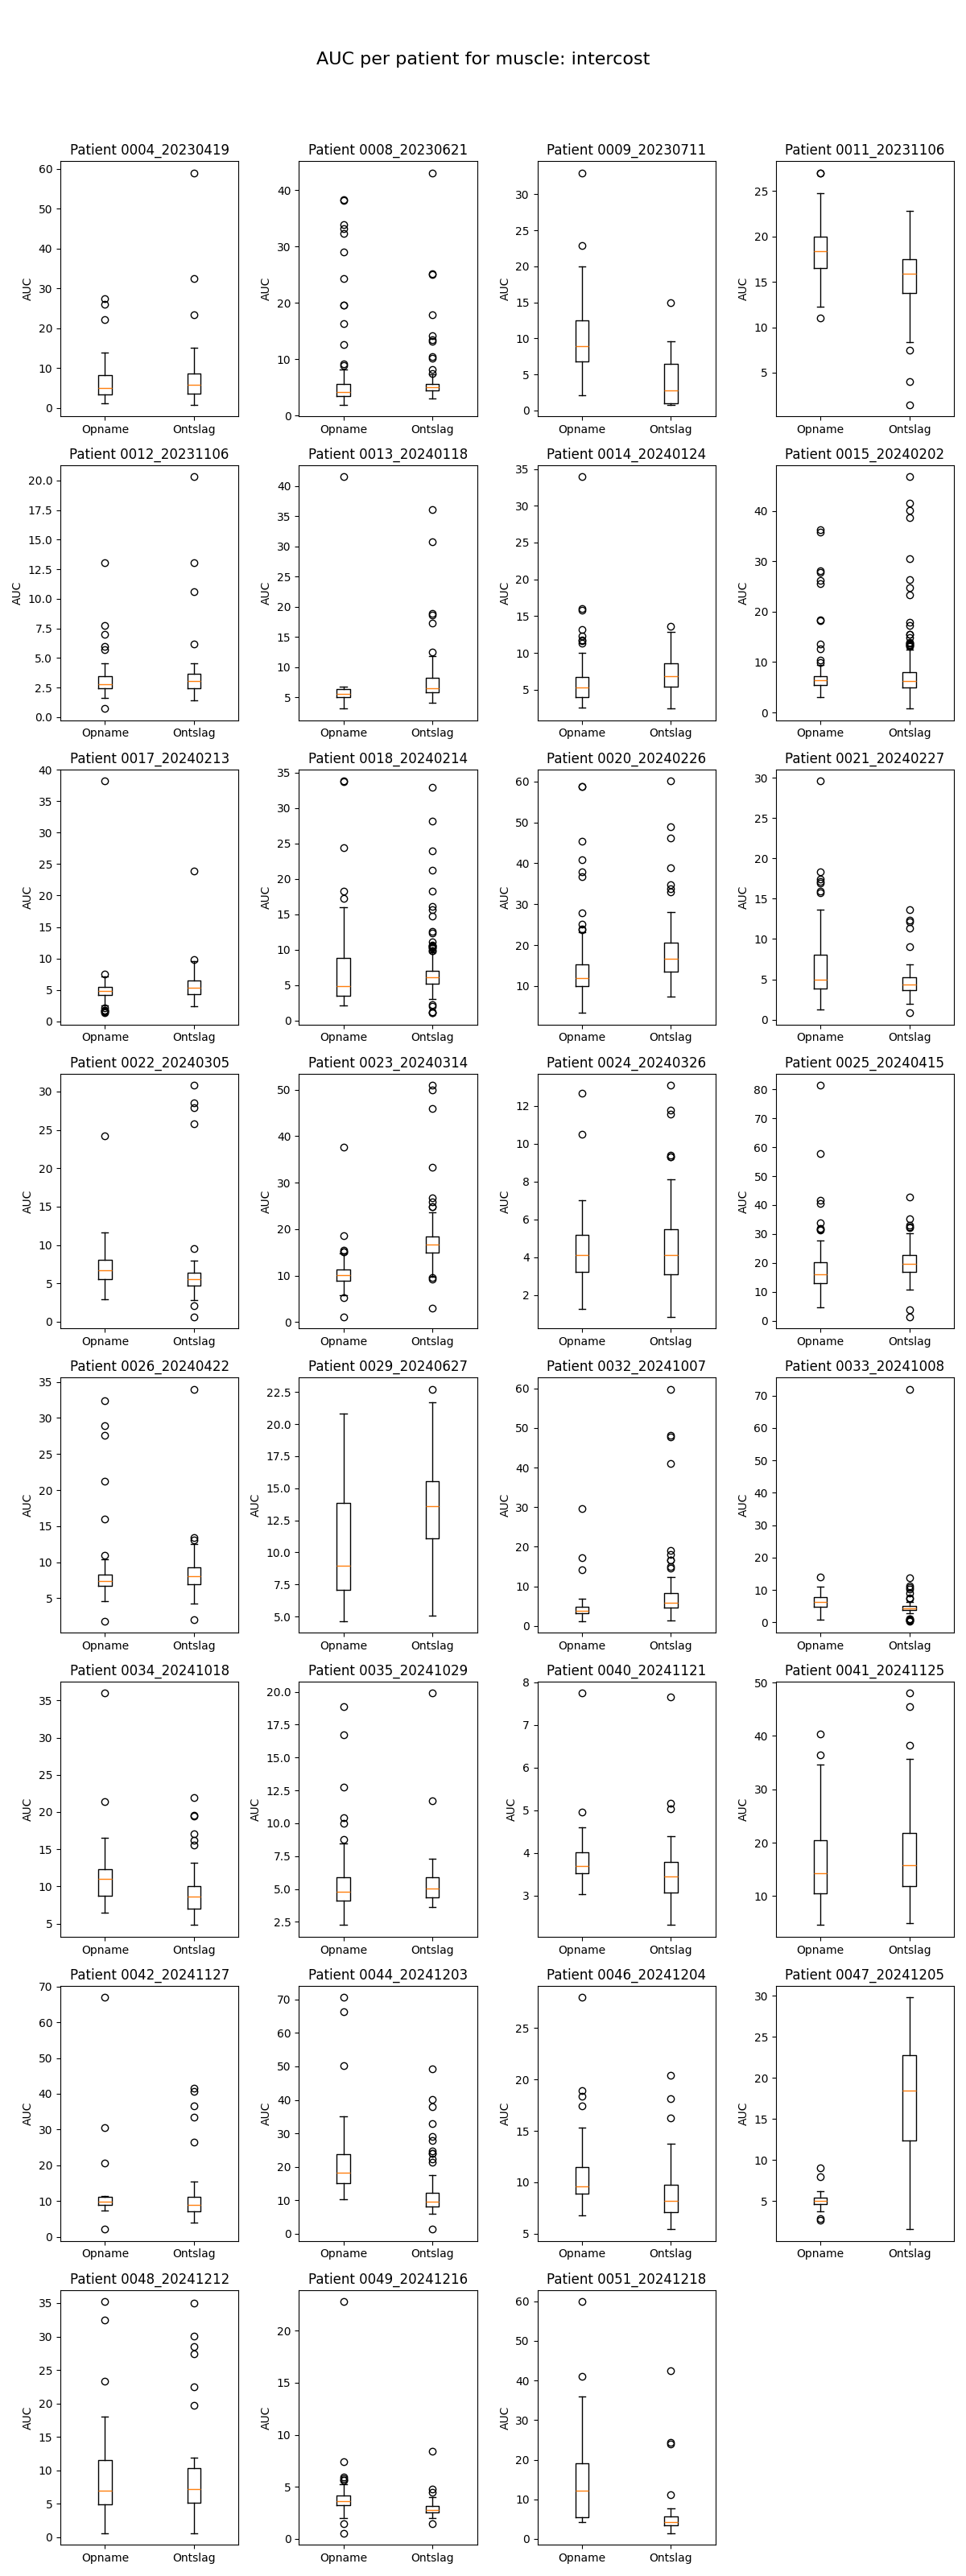

In [104]:
import matplotlib.pyplot as plt

# Prepare patient keys from opname dict
opname_keys = list(AUC_opname_dict.keys())
n_patients = len(opname_keys)
ncols = 4
nrows = (n_patients + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

for idx, opname_key in enumerate(opname_keys):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row][col]
    opname_data = AUC_opname_dict[opname_key]
    # Find ontslag key with same 3rd and 4th character
    opname_id = opname_key[2:4]
    ontslag_key = None
    for k in AUC_ontslag_dict:
        if k[2:4] == opname_id:
            ontslag_key = k
            break
    data = [opname_data]
    labels = ['Opname']
    if ontslag_key is not None:
        ontslag_data = AUC_ontslag_dict[ontslag_key]
        data.append(ontslag_data)
        labels.append('Ontslag')
    ax.boxplot(data, labels=labels)
    ax.set_title(f'Patient {opname_key}')
    ax.set_ylabel('AUC')

# Hide unused subplots
for idx in range(n_patients, nrows * ncols):
    row = idx // ncols
    col = idx % ncols
    axes[row][col].axis('off')

# Adjust the figure size to make it less broad (e.g., 3 * ncols width)
fig.set_size_inches(3 * ncols, 4 * nrows)
plt.tight_layout()
fig.suptitle(f'AUC per patient for muscle: {picked_muscle}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
# Generate an array that lists all patients in AUC_opname_dict
patients = list(AUC_opname_dict.keys())
print(patients)

['0004_20230419', '0005_20230525', '0007_20230620', '0008_20230621', '0009_20230711', '0010_20230926', '0011_20231106', '0012_20231106', '0013_20240118', '0014_20240124', '0015_20240202', '0016_20240208', '0017_20240213', '0018_20240214', '0019_20240216', '0020_20240226', '0021_20240227', '0022_20240305', '0023_20240314', '0024_20240326', '0025_20240415', '0026_20240422', '0028_20240530', '0029_20240627', '0030_20230926', '0031_20240916', '0032_20241007', '0033_20241008', '0034_20241018', '0035_20241029', '0036_20241118', '0037_20241119', '0038_20241120', '0039_20241121', '0040_20241121', '0041_20241125', '0042_20241127', '0044_20241203', '0045_20241204', '0046_20241204', '0047_20241205', '0048_20241212', '0049_20241216', '0050_20241217', '0051_20241218']


In [105]:
import pandas as pd
import numpy as np

# Prepare table rows
table_stats = []
for row in patients:
    pid = row[:4]  # Extract patient ID from the opname key
    #pid = row['Patient']
    # Find opname and ontslag keys for this patient
    opname_keys = [k for k in AUC_opname_dict if k.startswith(pid)]
    ontslag_keys = [k for k in AUC_ontslag_dict if k.startswith(pid)]
    # Gather all AUC values for opname and ontslag
    opname_vals = np.concatenate([AUC_opname_dict[k] for k in opname_keys]) if opname_keys else np.array([])
    ontslag_vals = np.concatenate([AUC_ontslag_dict[k] for k in ontslag_keys]) if ontslag_keys else np.array([])
    # Compute stats, use np.nan if empty
    opname_mean = np.mean(opname_vals) if opname_vals.size > 0 else np.nan
    opname_std = np.std(opname_vals, ddof=1) if opname_vals.size > 1 else np.nan
    opname_median = np.median(opname_vals) if opname_vals.size > 0 else np.nan
    ontslag_mean = np.mean(ontslag_vals) if ontslag_vals.size > 0 else np.nan
    ontslag_std = np.std(ontslag_vals, ddof=1) if ontslag_vals.size > 1 else np.nan
    ontslag_median = np.median(ontslag_vals) if ontslag_vals.size > 0 else np.nan
    table_stats.append({
        'Patient': pid,
        'Opname_mean': opname_mean,
        'Opname_sd': opname_std,
        'Opname_median': opname_median,
        'Ontslag_mean': ontslag_mean,
        'Ontslag_sd': ontslag_std,
        'Ontslag_median': ontslag_median
    })

# Create DataFrame and display
stats_df = pd.DataFrame(table_stats)
print(stats_df)

   Patient  Opname_mean  Opname_sd  Opname_median  Ontslag_mean  Ontslag_sd  \
0     0004     6.853856   5.353713       4.946378      7.372807    6.970362   
1     0005          NaN        NaN            NaN           NaN         NaN   
2     0007          NaN        NaN            NaN           NaN         NaN   
3     0008     7.985849   9.294072       4.190731      5.754882    4.030289   
4     0009    10.015310   5.720938       8.868028      4.269642    3.873124   
5     0010          NaN        NaN            NaN           NaN         NaN   
6     0011    18.280010   2.915479      18.372234     15.536617    3.663638   
7     0012     3.222824   1.649531       2.803313      4.252928    3.938595   
8     0013     6.858755   7.451272       5.605051      7.993115    5.048752   
9     0014     6.167725   4.056487       5.341576      7.096003    2.406207   
10    0015     6.848575   4.015828       6.348703      7.562012    5.914588   
11    0016          NaN        NaN            NaN   

C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_29900\1286549048.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_opname_auc, all_ontslag_auc], labels=['Opname', 'Ontslag'])


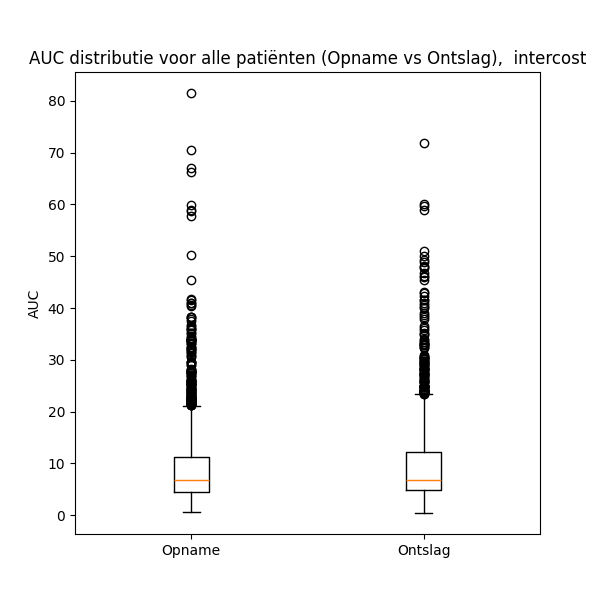

Gemiddelde AUC Opname: 9.15, intercost 
Gemiddelde AUC Ontslag: 9.40,  intercost


In [106]:
# Verzamel alle opname en ontslag AUC-waarden in aparte lijsten
all_opname_auc = [v for arr in AUC_opname_dict.values() for v in arr]
all_ontslag_auc = [v for arr in AUC_ontslag_dict.values() for v in arr]

# Maak een boxplot met beide groepen
plt.figure(figsize=(6, 6))
plt.boxplot([all_opname_auc, all_ontslag_auc], labels=['Opname', 'Ontslag'])
plt.ylabel('AUC')
plt.title(f'AUC distributie voor alle patiënten (Opname vs Ontslag),  {picked_muscle}')
plt.show()
print(f"Gemiddelde AUC Opname: {np.mean(all_opname_auc):.2f}, {picked_muscle} ")
print(f"Gemiddelde AUC Ontslag: {np.mean(all_ontslag_auc):.2f},  {picked_muscle}")

In [107]:
import numpy as np

import scipy.stats as stats

# Gather mean AUC per patient for opname and ontslag, only if both exist
opname_means = []
ontslag_means = []

for pid in set(k[:4] for k in AUC_opname_dict.keys()).intersection(k[:4] for k in AUC_ontslag_dict.keys()):
    opname_vals = np.concatenate([AUC_opname_dict[k] for k in AUC_opname_dict if k.startswith(pid)])
    ontslag_vals = np.concatenate([AUC_ontslag_dict[k] for k in AUC_ontslag_dict if k.startswith(pid)])
    if opname_vals.size > 0 and ontslag_vals.size > 0:
        opname_means.append(np.mean(opname_vals))
        ontslag_means.append(np.mean(ontslag_vals))

# Paired t-test
t_stat, p_value = stats.ttest_rel(opname_means, ontslag_means)
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_value:.4f}")

if p_value < 0.05:
    print("There is a significant difference between mean AUC at opname and ontslag.")
else:
    print("There is NO significant difference between mean AUC at opname and ontslag.")

Paired t-test: t = 0.132, p = 0.8957
There is NO significant difference between mean AUC at opname and ontslag.


In [108]:
import statsmodels.formula.api as smf

# Combineer alle opname en ontslag AUC-waarden in één DataFrame
# Maak een lijst van dicts met keys: 'AUC', 'Moment', 'Patient'
records = []
for opname_key, aucs in AUC_opname_dict.items():
    patient_id = opname_key[2:6]  # patientnummer uit de key
    for auc in aucs:
        records.append({'AUC': auc, 'Moment': 'Opname', 'Patient': patient_id})
for ontslag_key, aucs in AUC_ontslag_dict.items():
    patient_id = ontslag_key[2:6]
    for auc in aucs:
        records.append({'AUC': auc, 'Moment': 'Ontslag', 'Patient': patient_id})

df_auc = pd.DataFrame(records)

# Mixed-effects model: AUC ~ Moment + (1|Patient)
# Zet 'Moment' als categorische variabele
df_auc['Moment'] = pd.Categorical(df_auc['Moment'], categories=['Opname', 'Ontslag'])

# Fit het mixed-effects model
model = smf.mixedlm("AUC ~ Moment", df_auc, groups=df_auc["Patient"])
result = model.fit()

# Print samenvatting en p-waarde voor het verschil tussen opname en ontslag
print(result.summary())
p_value = result.pvalues['Moment[T.Ontslag]']
print(f"P-waarde voor verschil tussen opname en ontslag: {p_value:.4f}, {picked_muscle}")

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  AUC        
No. Observations:  5503     Method:              REML       
No. Groups:        31       Scale:               31.3336    
Min. group size:   31       Log-Likelihood:      -17355.8399
Max. group size:   498      Converged:           Yes        
Mean group size:   177.5                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          9.024    0.808 11.174 0.000  7.441 10.607
Moment[T.Ontslag]  0.386    0.159  2.434 0.015  0.075  0.697
Group Var         19.710    0.921                           

P-waarde voor verschil tussen opname en ontslag: 0.0149, intercost


In [109]:
import pandas as pd

# Create a summary table with the number of observations per patient for opname and ontslag


# Extract patient IDs from the keys (first 4 or 6 characters, depending on your convention)
def get_patient_id(key):
    # Use 4 characters for patient number, e.g., '0004', '0051'
    return key[:4]

# Prepare data for the table
summary_data = []
all_patient_ids = set([get_patient_id(k) for k in AUC_opname_dict.keys()] + [get_patient_id(k) for k in AUC_ontslag_dict.keys()])

for pid in sorted(all_patient_ids):
    opname_count = 0
    ontslag_count = 0
    # Find opname and ontslag keys for this patient
    opname_keys = [k for k in AUC_opname_dict if get_patient_id(k) == pid]
    ontslag_keys = [k for k in AUC_ontslag_dict if get_patient_id(k) == pid]
    if opname_keys:
        opname_count = sum(len(AUC_opname_dict[k]) for k in opname_keys)
    if ontslag_keys:
        ontslag_count = sum(len(AUC_ontslag_dict[k]) for k in ontslag_keys)
    summary_data.append({'Patient': pid, 'Opname_n': opname_count, 'Ontslag_n': ontslag_count})

# Create DataFrame
obs_table = pd.DataFrame(summary_data)
print(obs_table)

   Patient  Opname_n  Ontslag_n
0     0004        57         98
1     0008        67        170
2     0009        48         20
3     0011       109        107
4     0012        72         29
5     0013        24         77
6     0014        86        195
7     0015       259        239
8     0017       172        173
9     0018       129        298
10    0020       103         83
11    0021        55         78
12    0022        96         56
13    0023       156        221
14    0024        26         82
15    0025        95        125
16    0026       181        104
17    0029        20         62
18    0032       101        118
19    0033        22         74
20    0034        43         91
21    0035       114         14
22    0040        16         54
23    0041       124         79
24    0042        16         67
25    0044        84         93
26    0046        46         51
27    0047        15         16
28    0048        24         38
29    0049       122         70
30    00

In [110]:
import pandas as pd

# Prepare a table where each row is a patient, with columns for opname filename(s), ontslag filename(s), and day difference(s)
rows = []

for pid in sorted(set(k[:4] for k in AUC_opname_dict.keys()).union(k[:4] for k in AUC_ontslag_dict.keys())):
    # Find all opname and ontslag keys for this patient
    opname_keys = [k for k in AUC_opname_dict if k.startswith(pid)]
    ontslag_keys = [k for k in AUC_ontslag_dict if k.startswith(pid)]
    # Get the 13-character filename for each
    opname_files = [k[:13] for k in opname_keys]
    ontslag_files = [k[:13] for k in ontslag_keys]
    # Compute day difference for each pair (if both exist)
    day_diffs = []
    for o, s in zip(opname_files, ontslag_files):
        try:
            # Parse opname and ontslag as YYYYMMDD
            opname_date = o[5:13]
            ontslag_date = s[5:13]
            opname_dt = pd.to_datetime(opname_date, format='%Y%m%d')
            ontslag_dt = pd.to_datetime(ontslag_date, format='%Y%m%d')
            day_diffs.append((ontslag_dt - opname_dt).days)
        except Exception:
            day_diffs.append(None)
    # Pad lists to equal length for display
    max_len = max(len(opname_files), len(ontslag_files), len(day_diffs))
    opname_files += [''] * (max_len - len(opname_files))
    ontslag_files += [''] * (max_len - len(ontslag_files))
    day_diffs += [''] * (max_len - len(day_diffs))
    rows.append({
        'Patient': pid,
        'Opname_files': opname_files,
        'Ontslag_files': ontslag_files,
        'Day_diff': day_diffs
    })

# Convert to DataFrame for display
table_rows = []
for row in rows:
    for i in range(len(row['Opname_files'])):
        table_rows.append({
            'Patient': row['Patient'],
            'Opname_file': row['Opname_files'][i],
            'Ontslag_file': row['Ontslag_files'][i],
            'Day_diff': row['Day_diff'][i]
        })
patient_file_table = pd.DataFrame(table_rows)
print(patient_file_table)


   Patient    Opname_file   Ontslag_file  Day_diff
0     0004  0004_20230419  0004_20230421         2
1     0008  0008_20230621  0008_20230622         1
2     0009  0009_20230711  0009_20230714         3
3     0011  0011_20231106  0011_20231107         1
4     0012  0012_20231106  0012_20231107         1
5     0013  0013_20240118  0013_20240124         6
6     0014  0014_20240124  0014_20240131         7
7     0015  0015_20240202  0015_20240209         7
8     0017  0017_20240213  0017_20240214         1
9     0018  0018_20240214  0018_20240223         9
10    0020  0020_20240226  0020_20240229         3
11    0021  0021_20240227  0021_20240229         2
12    0022  0022_20240305  0022_20240307         2
13    0023  0023_20240314  0023_20240316         2
14    0024  0024_20240326  0024_20240329         3
15    0025  0025_20240415  0025_20240419         4
16    0026  0026_20240422  0026_20240423         1
17    0029  0029_20240627  0029_20240628         1
18    0032  0032_20241007  0032

### seperated steps below

In [16]:
# If you want to select another file:
btn_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('0004\\20230419T113930\\20230419_113930.Data14Ch…

In [49]:
# Load the EMG  data recordings from the selected folders. RAW files
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
data_emg = Poly5Reader(emg_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
n_ch = 4
# Define the time series of the EMG recording
y_emg = data_emg_samples[:n_ch,:]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]

Reading file  P:\TNW\CRPH\Projects\2025_Mos_Isala\Raw_data\0013\20240118T123612\20240118_123613.Data8Raw.Poly5
	 Number of samples:  272025 
	 Number of channels:  21 
	 Sample rate: 500 Hz
Done reading data.


In [50]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['Intercost','Dia R','Dia L', 'Abd'],
    units=n_ch*['uV'])

No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.


# 3. Pre-process the data

In [56]:
# Filter
emg_timeseries.run('filter_emg', hp_cf=20.0,lp_cf=200)

In [61]:
# set ecg channel to channel 0
emg_timeseries.set_ecg_idx(0)
# apply gating according to QRS peaks in ECG channel
emg_timeseries.run('gating',
   gate_width_samples=fs_emg//4, overwrite=True)

Set ECG channel used for ECG removal.


In [62]:
emg_timeseries.run('envelope',env_window=100)

In [63]:
emg_timeseries.run('baseline')

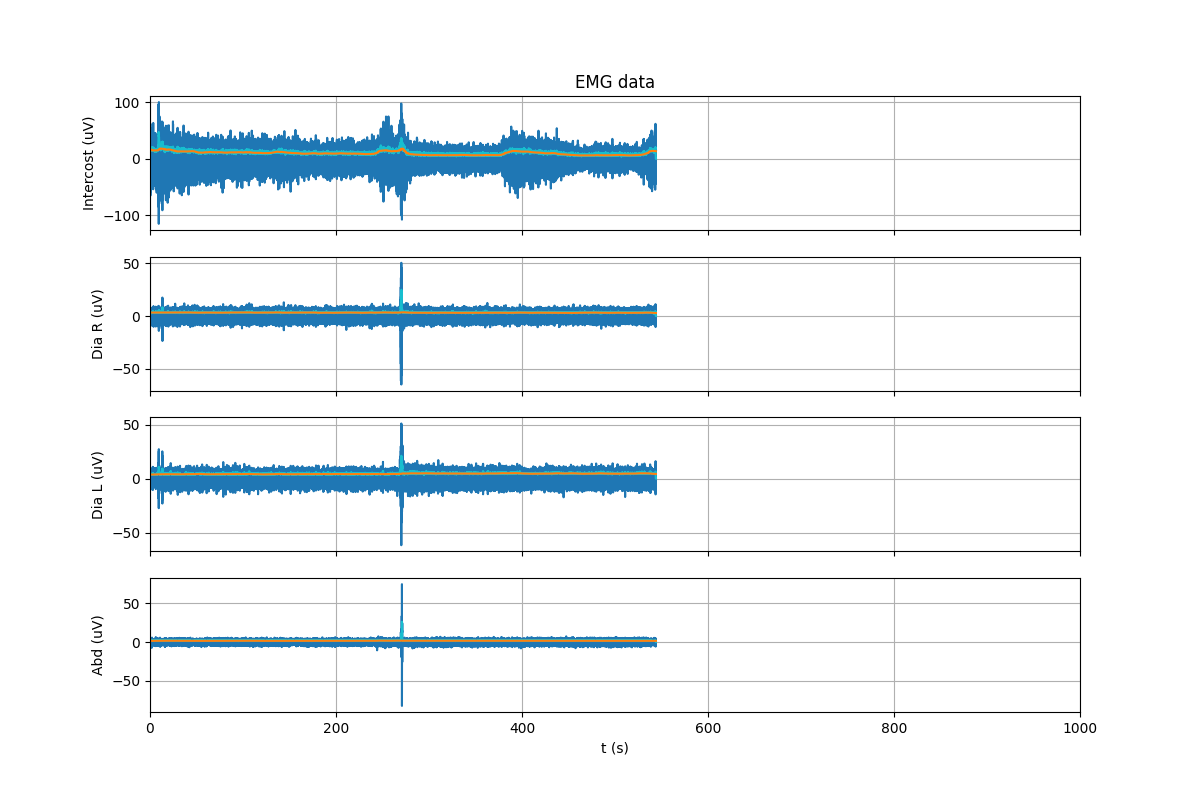

In [64]:
# Plot the raw data with the envelope
n_ch=4
fig, axis = plt.subplots(nrows=n_ch, ncols=1, figsize=(12, n_ch/3*6), sharex=True)
axes_emg = axis[:n_ch]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run('plot_full',
    axes=axes_emg, signal_type='clean', baseline_bool=False)

emg_timeseries.run('plot_full',axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')
for ax in axes_emg:
    #ax.set_ylim(-100, 100)
    ax.set_xlim(0,1000)

# 3. Identify all sEMG breaths

In [116]:
# Find sEAdi peaks
intercost = emg_timeseries.channels[0]
intercost.detect_emg_breaths(peak_set_name='breaths')
intercost.peaks['breaths'].detect_on_offset(
    baseline=intercost.y_baseline)

emg_di_r = emg_timeseries.channels[1]
emg_di_r.detect_emg_breaths(peak_set_name='breaths')
emg_di_r.peaks['breaths'].detect_on_offset(
    baseline=emg_di_r.y_baseline
)
emg_di_l = emg_timeseries.channels[2]
emg_di_l.detect_emg_breaths(peak_set_name='breaths')
emg_di_l.peaks['breaths'].detect_on_offset(
    baseline=emg_di_l.y_baseline
)

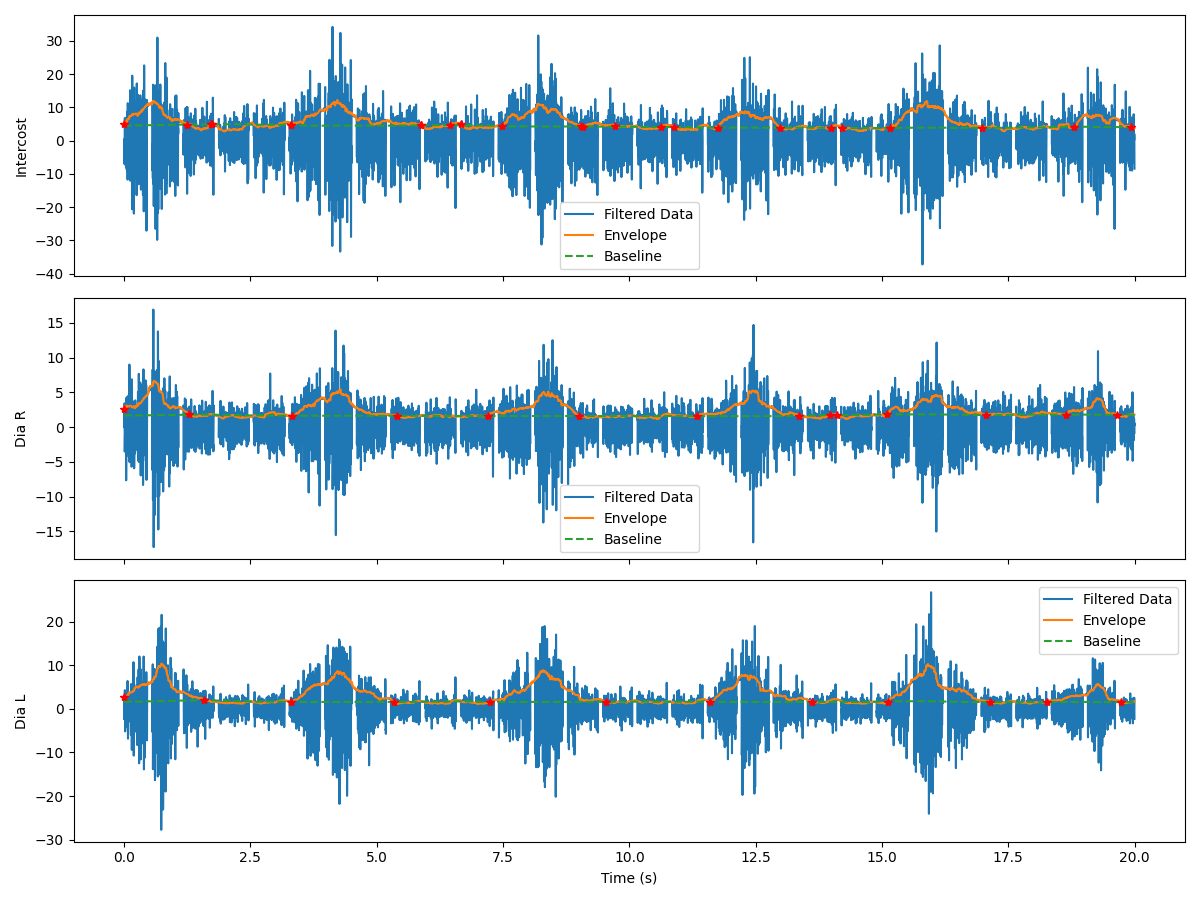

In [117]:
# Define the time range for the first 20 seconds
time_range = 20  # seconds
end_idx = int(time_range * fs_emg)
n_ch=3
# Create a figure with subplots for each channel
fig, axes = plt.subplots(nrows=n_ch, ncols=1, figsize=(12, n_ch * 3), sharex=True)

# Plot each channel
for i in range(n_ch):
    # Extract the segments of the signals
    filtered_segment = emg_timeseries.channels[i].y_clean[:end_idx]
    envelope_segment = emg_timeseries.channels[i].y_env[:end_idx]
    baseline_segment = emg_timeseries.channels[i].y_baseline[:end_idx]
    time_segment = emg_timeseries.channels[i].t_data[:end_idx]

    # Plot the segments
    axes[i].plot(time_segment, filtered_segment, label='Filtered Data', linestyle='-')
    axes[i].plot(time_segment, envelope_segment, label='Envelope', linestyle='-')
    axes[i].plot(time_segment, baseline_segment, label='Baseline', linestyle='--')

    # Plot the markers manually with red asterisks
    for peak in emg_timeseries.channels[i].peaks['breaths'].peak_df.itertuples():
        if peak.start_idx < end_idx:
            axes[i].plot(emg_timeseries.channels[i].t_data[peak.start_idx], emg_timeseries.channels[i].y_env[peak.start_idx], 'r*')  # Start marker
        if peak.end_idx < end_idx:
            axes[i].plot(emg_timeseries.channels[i].t_data[peak.end_idx], emg_timeseries.channels[i].y_env[peak.end_idx], 'r*')      # End marker

    # Add titles and labels
    axes[i].set_ylabel(emg_timeseries.channels[i].label)
    axes[i].legend()

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

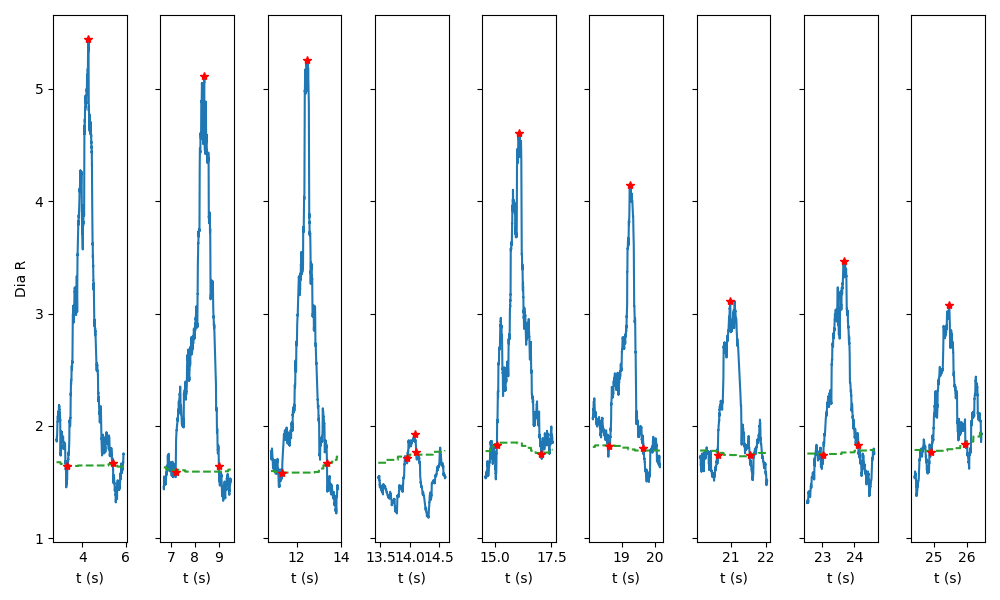

In [118]:
# Select the peaks to plot
peak_df = emg_di_r.peaks['breaths'].peak_df.iloc[1:10]

# Define the number of samples to plot before and after the peak
margin_samples = fs_emg // 2  # Half a second before and after

# Plot the selected peaks for sEAdi
n_peaks = len(peak_df)
fig, axis = plt.subplots(nrows=1, ncols=n_peaks, figsize=(10, 6), sharey='row')

# Ensure axes_emg is always a list of axes
if n_peaks == 1:
    axes_emg = [axis]
else:
    axes_emg = axis[:]

colors = ['tab:cyan', 'tab:orange', 'tab:red']

# Plot each selected peak individually
for i, row in enumerate(peak_df.itertuples()):
    start_idx = max(row.start_idx - margin_samples, 0)
    end_idx = min(row.end_idx + margin_samples, len(emg_di_r.y_env))

    # Extract the segment of the signal corresponding to the peak
    segment = emg_di_r.y_env[start_idx:end_idx]
    time = emg_di_r.t_data[start_idx:end_idx]

    # Plot the segment
    axes_emg[i].plot(time, segment, color='tab:blue')

    # Plot the baseline
    baseline_segment = emg_di_r.y_baseline[start_idx:end_idx]
    axes_emg[i].plot(time, baseline_segment, color='tab:green', linestyle='--')

    # Plot the markers manually with red asterisks
    axes_emg[i].plot(emg_di_r.t_data[row.start_idx], emg_di_r.y_env[row.start_idx], 'r*')  # Start marker
    axes_emg[i].plot(emg_di_r.t_data[row.end_idx], emg_di_r.y_env[row.end_idx], 'r*')      # End marker
    peak_idx = row.peak_idx
    axes_emg[i].plot(emg_di_r.t_data[peak_idx], emg_di_r.y_env[peak_idx], 'r*')           # Peak marker

# Set labels
axes_emg[0].set_ylabel(emg_di_r.label)
for ax in axes_emg:
    ax.set_xlabel('t (s)')

plt.tight_layout()
plt.show()


# 5. Calculate features

In [119]:
# Respiratory rate

emg_di_idxs_r = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_di_r, _ = feat.respiratory_rate(emg_di_idxs_r, fs_emg)

emg_di_idxs_l = emg_di_l.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_di_l, _ = feat.respiratory_rate(emg_di_idxs_l, fs_emg)

emg_di_idxs_int = intercost.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_intercost, _ = feat.respiratory_rate(emg_di_idxs_int, fs_emg)

print(rr_di_r)
print(rr_di_l)
print(rr_intercost)

38.96103896103896
24.330900243309003
51.02173630092412


In [120]:
# Get the indices of all detected breaths
breath_peak_idxs_di_r = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()
breath_peak_idxs_di_l = emg_di_l.peaks['breaths'].peak_df['peak_idx'].to_numpy()
breath_peak_idxs_intercost = intercost.peaks['breaths'].peak_df['peak_idx'].to_numpy()

# Calculate the amplitude of all detected breaths
sEAdi_amplitudes_dia_r = feat.amplitude(
    signal=emg_di_r.y_env,
    peak_idxs=breath_peak_idxs_di_r,
    baseline=emg_di_r.y_baseline,
)

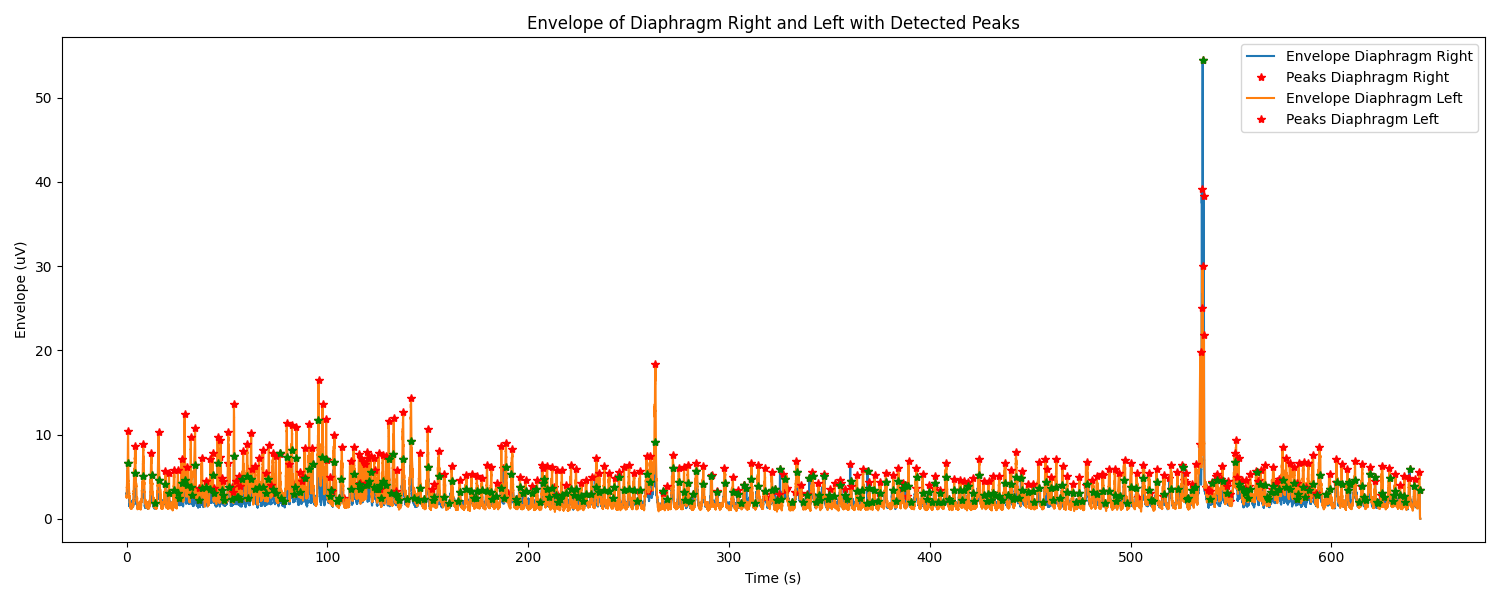

In [121]:
plt.figure(figsize=(15, 6))

# Plot envelope for right diaphragm
plt.plot(emg_di_r.t_data, emg_di_r.y_env, label='Envelope Diaphragm Right', color='tab:blue')
plt.plot(emg_di_r.t_data[emg_di_idxs_r], emg_di_r.y_env[emg_di_idxs_r], 'r*', label='Peaks Diaphragm Right')

# Plot envelope for left diaphragm
plt.plot(emg_di_l.t_data, emg_di_l.y_env, label='Envelope Diaphragm Left', color='tab:orange')
plt.plot(emg_di_l.t_data[emg_di_idxs_l], emg_di_l.y_env[emg_di_idxs_l], 'r*', label='Peaks Diaphragm Left')

plt.xlabel('Time (s)')
plt.ylabel('Envelope (uV)')
plt.title('Envelope of Diaphragm Right and Left with Detected Peaks')
plt.legend()
plt.tight_layout()
# Overlay green asterisks for valid peaks (right diaphragm)
valid_peaks_r = emg_di_r.peaks['breaths'].peak_df[emg_di_r.peaks['breaths'].peak_df['valid'] == True]['peak_idx'].to_numpy()
plt.plot(emg_di_r.t_data[valid_peaks_r], emg_di_r.y_env[valid_peaks_r], 'g*', label='Valid Peaks Diaphragm Right')

plt.show()

In [122]:
# Calculate the area under the curve (AUC) for all detected breaths
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')
emg_di_l.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')
intercost.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')

# Store the AUC values in a variable
#sEAdi_auc_di_r = emg_di_r.peaks['breaths'].peak_df['AUC'].to_numpy()


# 6. Test sEMG quality

In [123]:
# Test EMG quality
parameter_names = {
    'time_product': 'AUC'
}
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)
emg_di_l.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)
intercost.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_8324\1056047460.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


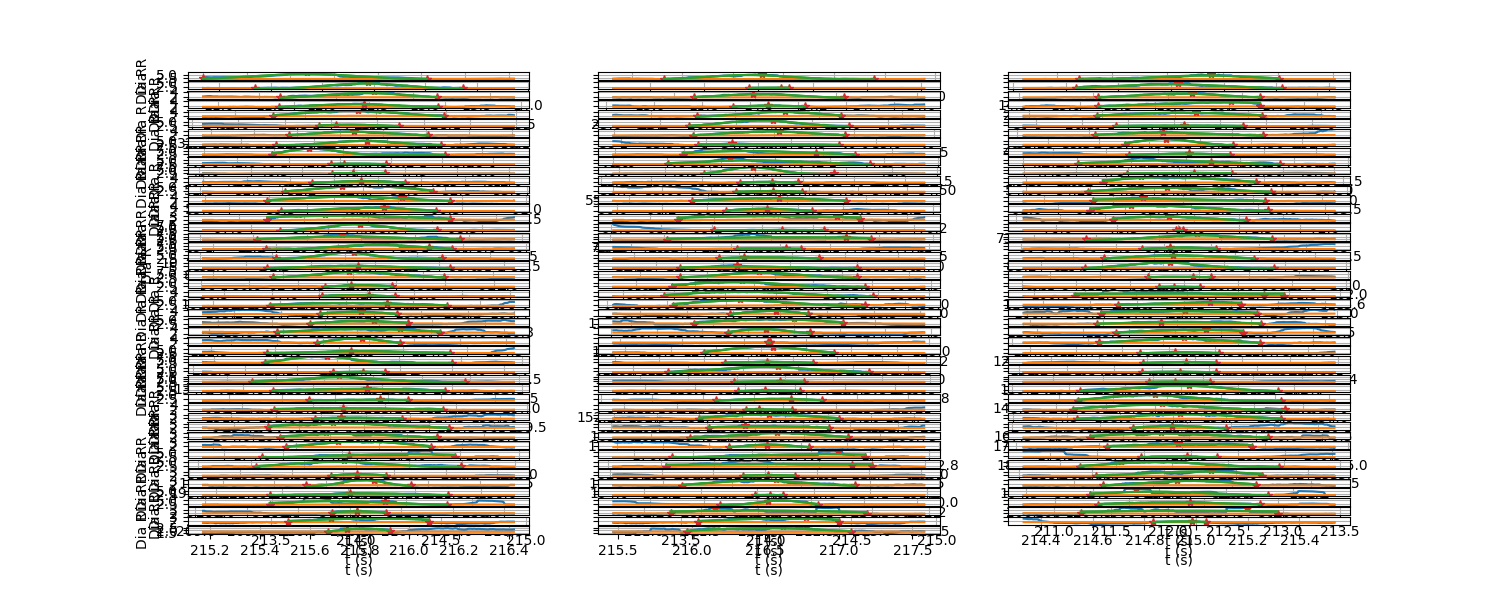

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame to include only valid peaks
valid_peaks_df_di_r = emg_di_r.peaks['breaths'].peak_df[emg_di_r.peaks['breaths'].peak_df['valid'] == True]
valid_peaks_df_di_l = emg_di_l.peaks['breaths'].peak_df[emg_di_l.peaks['breaths'].peak_df['valid'] == True]
valid_peaks_df_intercost = intercost.peaks['breaths'].peak_df[intercost.peaks['breaths'].peak_df['valid'] == True]

# Get the number of valid peaks
n_peaks = len(valid_peaks_df_di_r['start_idx'].to_numpy())

# Define the maximum number of columns
max_cols = 3

# Calculate the number of rows needed
n_rows = int(np.ceil(n_peaks / max_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=max_cols, figsize=(15, 6), sharey='row')

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Ensure axes_emg is always a list of axes
axes_emg = axes_flat[:n_peaks]

colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di_r.plot_peaks(axes=axes_emg, peak_set_name='breaths')
emg_di_r.plot_markers(axes=axes_emg, peak_set_name='breaths')
emg_di_r.plot_curve_fits(axes=axes_emg, peak_set_name='breaths')

# Set labels for the first column and all axes
for i, axis in enumerate(axes_emg):
    if i % max_cols == 0:
        axis.set_ylabel(emg_di_r.label)
    axis.set_xlabel('t (s)')

# Hide any unused subplots
for j in range(n_peaks, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()


In [125]:
# data
total_detected_peaks_di_r = len(emg_di_r.peaks['breaths'].peak_df)
total_detected_peaks_di_l = len(emg_di_l.peaks['breaths'].peak_df)
total_detected_peaks_intercost = len(intercost.peaks['breaths'].peak_df)

num_valid_breaths_di_r = len(valid_peaks_df_di_r)
num_valid_breaths_di_l = len(valid_peaks_df_di_l)
num_valid_breaths_intercost = len(valid_peaks_df_intercost)

mean_auc_di_r = valid_peaks_df_di_r['AUC'].mean()
mean_auc_di_l = valid_peaks_df_di_l['AUC'].mean()
mean_auc_intercost = valid_peaks_df_intercost['AUC'].mean()

median_auc_di_r = valid_peaks_df_di_r['AUC'].median()
median_auc_di_l = valid_peaks_df_di_l['AUC'].median()
median_auc_intercost = valid_peaks_df_intercost['AUC'].median()

std_auc_di_r = valid_peaks_df_di_r['AUC'].std()
std_auc_di_l = valid_peaks_df_di_l['AUC'].std()
std_auc_intercost = valid_peaks_df_intercost['AUC'].std()


In [22]:
A=emg_timeseries[0].peaks['breaths'].peak_df

In [23]:
A.to_csv('P:/TNW/CRPH/Projects/2025_Mos_Isala/A.csv', index=False)

In [48]:
excel_path = 'P:/TNW/CRPH/Projects/2025_Mos_Isala/data.xlsx'
file_name = os.path.basename(emg_file_chosen).replace('.Data8Raw.Poly5', '')
patient_number = os.path.basename(os.path.dirname(os.path.dirname(emg_file_chosen)))
results = [
    patient_number,
    file_name,
    total_detected_peaks_di_r,
    num_valid_breaths_di_r,
    mean_auc_di_r,
    median_auc_di_r,
    std_auc_di_r,
    total_detected_peaks_di_l,
    num_valid_breaths_di_l,
    mean_auc_di_l,
    median_auc_di_l,
    std_auc_di_l,
    total_detected_peaks_intercost,
    num_valid_breaths_intercost,
    mean_auc_intercost,
    median_auc_intercost,
    std_auc_intercost
]

try:
    df = pd.read_excel(excel_path, header=None, engine='openpyxl')
except FileNotFoundError:
    df = pd.DataFrame()

first_empty_row = len(df)
for i, value in enumerate(results):
    df.at[first_empty_row, i] = value

df.to_excel(excel_path, index=False, header=False)

The number of breaths in valid peaks is 171.


NameError: name 'mean_auc' is not defined

### notes from here


In [24]:
# Calculate the number of breaths in valid peaks

print(f"The number of breaths in valid peaks is {num_valid_breaths_di_r}.")

print(f"The mean value of the attribute 'auc' for the valid breaths is {mean_auc}.")
# Calculate the median value of the attribute 'aub' for the valid breaths

print(f"The median value of the attribute 'auc' for the valid breaths is {median_auc}.")
# Calculate the standard deviation of the attribute 'aub' for the valid breaths

print(f"The standard deviation of the attribute 'auc' for the valid breaths is {std_auc}.")



The number of breaths in valid peaks is 6.


NameError: name 'mean_auc' is not defined

In [25]:
#print(emg_di_r.peaks['breaths'].quality_outcomes_df)

# Print all lines that have a False value in any of the specified columns
false_rows = quality_outcomes_df[columns_to_check].apply(lambda row: row == False, axis=1)
print(quality_outcomes_df[false_rows.any(axis=1)])

NameError: name 'quality_outcomes_df' is not defined

In [26]:
# The peak-validity is updated in the peak_df:
print(emg_di_r.peaks['breaths'].peak_df)

     peak_idx  start_idx  end_idx  valid       AUB     aub_y_ref       AUC  \
0         542        472      572  False  0.154800  1.875216e+00  0.211589   
1        1378        876     1735  False  1.276224  1.875216e+00  2.918957   
2        2677       2629     2735  False  0.165618  1.875216e+00  0.222723   
3        3100       2995     3364  False  0.523365  1.953416e+00  0.983287   
4        3500       3410     3620  False  0.297850  1.953416e+00  0.417686   
..        ...        ...      ...    ...       ...           ...       ...   
464    287431     287133   287746  False  0.684780  1.638632e+00  1.437985   
465    288376     288049   288599  False  0.605769  1.638632e+00  0.958466   
466    289317     289240   289700  False  1.915259  4.270917e-07  2.521438   
467    289990     289785   290083  False  1.222349  4.270917e-07  1.341005   
468    290402     290107   290561  False  1.812166  4.270917e-07  2.030911   

       bell_y_min    bell_a      bell_b    bell_c  
0    1.8752

In [27]:
# Calculate the number of breaths in valid peaks
num_valid_breaths = len(valid_peaks_df)

print(f"The number of breaths in valid peaks is {num_valid_breaths}.")

mean_auc = valid_peaks_df['AUC'].mean()
print(f"The mean value of the attribute 'auc' for the valid breaths is {mean_auc}.")
# Calculate the median value of the attribute 'aub' for the valid breaths
median_auc = valid_peaks_df['AUC'].median()

print(f"The median value of the attribute 'auc' for the valid breaths is {median_auc}.")
# Calculate the standard deviation of the attribute 'aub' for the valid breaths
std_auc = valid_peaks_df['AUC'].std()

print(f"The standard deviation of the attribute 'auc' for the valid breaths is {std_auc}.")



NameError: name 'valid_peaks_df' is not defined

In [135]:
# Detect local high baselines in EMGdi
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUB')
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


emg_di_aubs = emg_di_r.peaks['breaths'].peak_df['AUB'].to_numpy()
valid_aubs = qa.detect_local_high_aub(
    aubs=emg_di_aubs,
    threshold_percentile=75,
    threshold_factor=4,
)
valid_aubs


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [136]:
ETPdi_r_list = emg_di_r.peaks['breaths'].peak_df['AUB'].to_numpy()
valid_etps = qa.detect_extreme_time_products(
    ETPdi_r_list,
    upper_percentile=95.0,
    upper_factor=10.0,
    lower_percentile=5.0,
    lower_factor=.1,
)
valid_etps


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [137]:
print(len(emg_di_r.peaks['breaths']))

349


In [ ]:
import matplotlib.pyplot as plt

# Define the breath number you want to plot
breath_number = 14  # Change this to the desired breath number

# Ensure the breath number is within the valid range
if breath_number < 1 or breath_number > len(emg_di_r.peaks['breaths'].quality_outcomes_df) - 2:
    raise ValueError("Breath number out of range. Please choose a number between 1 and {}.".format(len(emg_di_r.peaks['breaths'].quality_outcomes_df) - 2))

# Get the indices of the breaths to plot
start_idx = emg_di_r.peaks['breaths'].quality_outcomes_df.iloc[breath_number]['peak_idx']-2000
end_idx = emg_di_r.peaks['breaths'].quality_outcomes_df.iloc[breath_number + 4]['peak_idx']+500
# Extract the segments of the signals
filtered_segment = emg_di_r.y_clean[start_idx:end_idx]
envelope_segment = emg_di_r.y_env[start_idx:end_idx]
baseline_segment = emg_di_r.y_baseline[start_idx:end_idx]
time_segment = emg_di_r.t_data[start_idx:end_idx]

# Plot the segments
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_segment, filtered_segment, label='Filtered Data', linestyle='-')
ax.plot(time_segment, envelope_segment, label='Envelope', linestyle='-')
ax.plot(time_segment, baseline_segment, label='Baseline', linestyle='--')

# Add titles and labels
ax.set_title('Selected Breath and Surrounding Data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (uV)')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
quality_outcomes_df = emg_di_r.peaks['breaths'].quality_outcomes_df

# Count the number of False values in each specified column
columns_to_check = ['baseline_detection', 'interpeak_distance', 'snr', 'aub', 'bell']
false_counts = quality_outcomes_df[columns_to_check].apply(lambda col: (col == False).sum())

# Print the results
print(false_counts)